datos de https://coronavirus.gob.mx/datos/#DownZCSV

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
from utils import load_dataset

import time
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [3]:
df_creibles = load_dataset("data/junio23.csv", 15)

In [4]:
X = df_creibles.drop("fallecio", axis=1)
y = df_creibles["fallecio"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0, stratify=y)
print(X_train.shape)
print(X_test.shape)

(136086, 14)
(34022, 14)


In [6]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""

    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(opt.cv_results_)    

    # Get current parameters and the best parameters    
    best_params = pd.Series(opt.best_params_)
    print(f"""
        Model {len(all_models)}
        Best roc_auc: { np.round(opt.best_score_, 4)}
        best_params: {opt.best_params_}
    """)

In [11]:
params_bayes = {
        'num_leaves': Integer(2, 100),
        'max_depth': Integer(1, 100),
        'min_child_weight': Integer(0, 10),
        'reg_lambda': Real(0.1, 0.9, 'log-uniform'),
        'reg_alpha': Real(0.01, 0.99, 'log-uniform'),
        'n_estimators': Integer(10, 100, 'log-uniform'),
        'feature_fraction': Real(0.01, 0.99, 'log-uniform'),
        'bagging_fraction': Real(0.01, 0.99, 'log-uniform'),
        'bagging_freq': Integer(1, 30, 'log-uniform'),
        'learning_rate': Real(0.0001, 0.99, 'log-uniform'),
        }

n_folds = 3
kf = StratifiedKFold(n_folds, shuffle=True)

pesos = {0: 0.1, 1:0.9}

model = lgbm.LGBMClassifier(boosting_type= 'dart',               
          objective = "binary", # este focal loss me da scores por fuera de 0 y 1
          n_jobs = -1, 
          silent = True,
          is_unbalance = True,
          metric="auc"
        ) 

opt = BayesSearchCV(model, params_bayes, n_iter=100, cv=kf, 
                    n_jobs=-1, scoring="roc_auc", verbose=0,
                    refit=True,
                    random_state=0)

In [14]:
opt.fit(X_train, y_train, callback=[status_print])


        Model 1
        Best roc_auc: 0.8529
        best_params: OrderedDict([('bagging_fraction', 0.11471250790720901), ('bagging_freq', 21), ('feature_fraction', 0.17486443877623334), ('learning_rate', 0.0383616370629944), ('max_depth', 86), ('min_child_weight', 10), ('n_estimators', 22), ('num_leaves', 2), ('reg_alpha', 0.14774481729196623), ('reg_lambda', 0.17029584298473538)])
    

        Model 2
        Best roc_auc: 0.8811
        best_params: OrderedDict([('bagging_fraction', 0.032780500630524984), ('bagging_freq', 29), ('feature_fraction', 0.6499973568318845), ('learning_rate', 0.0248171522779568), ('max_depth', 27), ('min_child_weight', 2), ('n_estimators', 80), ('num_leaves', 59), ('reg_alpha', 0.01719645076354461), ('reg_lambda', 0.15127954202425636)])
    

        Model 3
        Best roc_auc: 0.8811
        best_params: OrderedDict([('bagging_fraction', 0.032780500630524984), ('bagging_freq', 29), ('feature_fraction', 0.6499973568318845), ('learning_rate', 0.02481715

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
              error_score='raise',
              estimator=LGBMClassifier(boosting_type='dart', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       is_unbalance=True, learning_rate=0.1,
                                       max_depth=-1, metric='auc',
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=100,
                                       n_j...
                             'min_child_weight': Integer(low=0, high=10, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=10, high=100, prior='log-uniform', transform='identity'),
                             'num_leaves': Integer(low=2, high

In [15]:
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)
y_scores = best_model.predict_proba(X_test)[:,1]

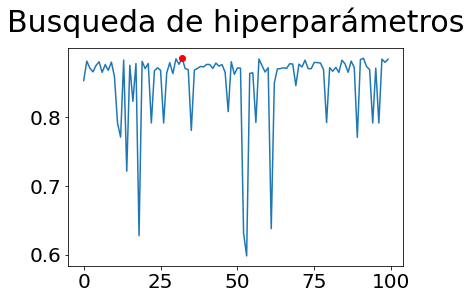

maximo encontrado en la iteracion: 32
media de iteraciones: 0.8514478303713369


In [18]:
index_max = np.argmax(opt.cv_results_["mean_test_score"])
maximo = np.max(opt.cv_results_["mean_test_score"])
ax = plt.subplot(1, 1, 1)
ax.plot(opt.cv_results_["mean_test_score"])
ax.plot(index_max, maximo, "or")
ax.tick_params(axis='both', which='major', labelsize=20)
plt.title("Busqueda de hiperparámetros", fontsize = 30)
ttl = ax.title
ttl.set_position([.5, 1.05])
plt.show()
print(f'maximo encontrado en la iteracion: {index_max}')
print(f'media de iteraciones: {np.mean(opt.cv_results_["mean_test_score"])}')

In [21]:
roc_auc_score(y_test, y_scores)

0.8853665586974393

In [26]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = f'models/lgbm_binary_auc_{timestr}.pkl'
joblib.dump(best_model, filename)

['models/lgbm_binary_auc_20200626-110602.pkl']